In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Import your custom modules
import config
import data_generation
from benchmarks import *

In [2]:
"""
Main function to run a single test of the NLS-ITS benchmark model.
"""
print("--- NLS-ITS Benchmark Test ---")

# --- 1. Select Scenario and Generate Data ---
scenario_to_test_id = "S06" # A good choice with K=2 interventions
test_seed = 42 # A fixed seed for reproducibility

try:
    scenario_config = next(s for s in config.SCENARIOS if s['id'] == scenario_to_test_id)
except StopIteration:
    print(f"Error: Scenario '{scenario_to_test_id}' not found in config.py")
    
print(f"Generating data for scenario: {scenario_to_test_id}...")
sim_data = data_generation.simulate_scenario_data(scenario_config, run_seed=test_seed)
print("Data generated successfully.")

--- NLS-ITS Benchmark Test ---
Generating data for scenario: S06...
Data generated successfully.


In [22]:
def calculate_its_with_nls(d_t, c_t, Bm, Z_orig, intervention_signs, alpha=0.05, n_mc_ci=500):
    """
    Estimates curves and parameters using an Orthogonalized NLS model.
    """
    T, K_spline = Bm.shape
    K_interventions = Z_orig.shape[1]
    num_params = K_spline + 2 * K_interventions

    # --- Orthogonalize Z with respect to Bm ---
    try:
        transform_matrix = np.linalg.pinv(Bm) @ Z_orig
        Z_ortho = Z_orig - (Bm @ transform_matrix)
    except np.linalg.LinAlgError:
        Z_ortho = Z_orig

    # --- Define the non-linear model function for curve_fit ---
    def nls_model(X_packed, *params):
        _t, _Bm, _Z_ortho = X_packed
        alphas_star = np.array(params[:K_spline])
        gammas = np.array(params[K_spline : K_spline + K_interventions])
        lambdas = np.array(params[K_spline + K_interventions:])
        
        # betas_abs = np.exp(gammas)
        # intervention_effect = np.sum((1 - np.exp(-lambdas * (np.maximum(0, _t[:, None] - intervention_times_abs))))) * (betas_abs * intervention_signs), axis=1)

        # The model is fit on the orthogonalized predictors
        baseline_trend = _Bm @ alphas_star
        return baseline_trend + np.sum((1 - np.exp(-lambdas * _Z_ortho)) * (np.exp(gammas) * intervention_signs), axis=1)

    # --- Prepare data and fit model ---
    t_array = np.arange(T)
    # (logic for logit_cfr_target remains the same)
    
    p0 = np.zeros(num_params)
    if K_interventions > 0: p0[K_spline + K_interventions:] = 0.1

    popt = np.full(num_params, np.nan)
    pcov = np.full((num_params, num_params), np.nan)

    try:
        # We need a way to pass Bm and Z_ortho to the function. We'll use a wrapper.
        def fit_func(t_indices, *params):
            return nls_model((t_indices, Bm, Z_ortho), *params)
        popt, pcov = curve_fit(fit_func, t_array, logit_cfr_target, p0=p0, maxfev=10000)
    except (RuntimeError, ValueError):
        print("Warning: NLS curve_fit failed. Returning NaNs for ITS benchmark.")

    # --- Post-Hoc Transformation and Confidence Intervals ---
    alpha_star_est = popt[:K_spline]
    gamma_est = popt[K_spline : K_spline + K_interventions]
    lambda_est = popt[K_spline + K_interventions:]

    # Calculate CIs for parameters from covariance matrix
    perr = np.sqrt(np.diag(pcov)) if not np.any(np.isnan(pcov)) else np.full_like(popt, np.nan)
    z_crit = norm.ppf(1 - alpha / 2)

    gamma_se, lambda_se = perr[K_spline : K_spline + K_interventions], perr[K_spline + K_interventions:]
    gamma_ci_lower, gamma_ci_upper = gamma_est - z_crit * gamma_se, gamma_est + z_crit * gamma_se
    lambda_ci_lower, lambda_ci_upper = lambda_est - z_crit * lambda_se, lambda_est + z_crit * lambda_se

    # Calculate Prediction CIs via Monte Carlo with post-hoc transform
    pred_factual_mc = np.full((n_mc_ci, T), np.nan)
    pred_counterfactual_mc = np.full((n_mc_ci, T), np.nan)
    cf_ci_lower, cf_ci_upper = np.full(T, np.nan), np.full(T, np.nan)

    if not np.any(np.isnan(pcov)):
        try:
            param_samples = np.random.multivariate_normal(popt, pcov, size=n_mc_ci)
            for i, p_sample in enumerate(param_samples):
                alpha_star_s, gamma_s, lambda_s = p_sample[:K_spline], p_sample[K_spline:K_spline+K_interventions], p_sample[K_spline+K_interventions:]
                
                # Factual prediction is from the original model structure
                beta_s = np.exp(gamma_s) * intervention_signs
                intervention_effect_s = np.sum((1 - np.exp(-lambda_s * Z_orig)) * beta_s, axis=1)
                pred_factual_mc[i, :] = Bm @ alpha_star_s + intervention_effect_s

                # ** Post-hoc transform for counterfactual **
                alpha_s_unbiased = alpha_star_s - (transform_matrix @ beta_s)
                pred_counterfactual_mc[i, :] = Bm @ alpha_s_unbiased
        except (np.linalg.LinAlgError, ValueError):
            print("Warning: NLS Covariance matrix not valid for MC sampling.")

    factual_ci_lower = sigmoid(np.percentile(pred_factual_mc, (alpha/2)*100, axis=0))
    factual_ci_upper = sigmoid(np.percentile(pred_factual_mc, (1-alpha/2)*100, axis=0))
    cf_ci_lower = sigmoid(np.percentile(pred_counterfactual_mc, (alpha/2)*100, axis=0))
    cf_ci_upper = sigmoid(np.percentile(pred_counterfactual_mc, (1-alpha/2)*100, axis=0))

    # Final point estimate for the counterfactual using the transformed alpha
    beta_hat = np.exp(gamma_est) * intervention_signs
    alpha_hat_unbiased = alpha_star_est - (transform_matrix @ beta_hat)
    
    return {
        "its_factual_mean": sigmoid(nls_model((t_array, Z_nls), *popt)),
        "its_factual_lower": factual_ci_lower,
        "its_factual_upper": factual_ci_upper,
        "its_counterfactual_mean": sigmoid(Bm @ alpha_hat_unbiased),
        "its_counterfactual_lower": cf_ci_lower,
        "its_counterfactual_upper": cf_ci_upper,
        "its_gamma_est": gamma_est,
        "its_gamma_lower": gamma_ci_lower,
        "its_gamma_upper": gamma_ci_upper,
        "its_lambda_est": lambda_est,
        "its_lambda_lower": lambda_ci_lower,
        "its_lambda_upper": lambda_ci_upper
    }

In [38]:
d_t=sim_data["d_t"]
c_t=sim_data["c_t"]
Bm=sim_data["Bm_true"]
Z_orig=sim_data["Z_input_true"]
intervention_signs=sim_data["beta_signs_true"]

alpha=0.05
n_mc_ci=500

T, K_spline = Bm.shape
K_interventions = Z_orig.shape[1]
num_params = K_spline + 2 * K_interventions

# --- Orthogonalize Z with respect to Bm ---
try:
    transform_matrix = np.linalg.pinv(Bm) @ Z_orig
    Z_ortho = Z_orig - (Bm @ transform_matrix)
except np.linalg.LinAlgError:
    Z_ortho = Z_orig

# --- Define the non-linear model function for curve_fit ---
def nls_model(X_packed, *params):
    _Bm, _Z_ortho = X_packed
    alphas_star = np.array(params[:K_spline])
    gammas = np.array(params[K_spline : K_spline + K_interventions])
    lambdas = np.array(params[K_spline + K_interventions:])
    
    # betas_abs = np.exp(gammas)
    # intervention_effect = np.sum((1 - np.exp(-lambdas * (np.maximum(0, _t[:, None] - intervention_times_abs)))) * (betas_abs * intervention_signs), axis=1)

     # The model is fit on the orthogonalized predictors
    baseline_trend = _Bm @ alphas_star
    return baseline_trend + np.sum((1 - np.exp(-lambdas * _Z_ortho)) * (np.exp(gammas) * intervention_signs), axis=1)
    
# --- Prepare data and fit model ---
daily_d_smooth = pd.Series(d_t).rolling(window=7, min_periods=1, center=True).mean().values
daily_c_smooth = pd.Series(c_t).rolling(window=7, min_periods=1, center=True).mean().values
with np.errstate(divide='ignore', invalid='ignore'):
    naive_cfr = daily_d_smooth / (daily_c_smooth + 1e-6)
    logit_cfr_target = logit(np.clip(naive_cfr, 1e-6, 1 - 1e-6))
logit_cfr_target = np.nan_to_num(logit_cfr_target, nan=np.median(logit_cfr_target[~np.isnan(logit_cfr_target)]))

p0 = np.zeros(num_params)
if K_interventions > 0: p0[K_spline + K_interventions:] = 0.1

popt = np.full(num_params, np.nan)
pcov = np.full((num_params, num_params), np.nan)

t_array = np.arange(T)

try:
    # We need a way to pass Bm and Z_ortho to the function. We'll use a wrapper.
    def fit_func(t_indices, *params):
            return nls_model((Bm, Z_ortho), *params)
    popt, pcov = curve_fit(fit_func, t_array, logit_cfr_target, p0=p0, maxfev=10000)
except (RuntimeError, ValueError):
    print("Warning: NLS curve_fit failed. Returning NaNs for ITS benchmark.")

# --- Post-Hoc Transformation and Confidence Intervals ---
alpha_star_est = popt[:K_spline]
gamma_est = popt[K_spline : K_spline + K_interventions]
lambda_est = popt[K_spline + K_interventions:]

# Calculate CIs for parameters from covariance matrix
perr = np.sqrt(np.diag(pcov)) if not np.any(np.isnan(pcov)) else np.full_like(popt, np.nan)
z_crit = norm.ppf(1 - alpha / 2)

gamma_se, lambda_se = perr[K_spline : K_spline + K_interventions], perr[K_spline + K_interventions:]
gamma_ci_lower, gamma_ci_upper = gamma_est - z_crit * gamma_se, gamma_est + z_crit * gamma_se
lambda_ci_lower, lambda_ci_upper = lambda_est - z_crit * lambda_se, lambda_est + z_crit * lambda_se

# Calculate Prediction CIs via Monte Carlo with post-hoc transform
pred_factual_mc = np.full((n_mc_ci, T), np.nan)
pred_counterfactual_mc = np.full((n_mc_ci, T), np.nan)
cf_ci_lower, cf_ci_upper = np.full(T, np.nan), np.full(T, np.nan)

if not np.any(np.isnan(pcov)):
    try:
        param_samples = np.random.multivariate_normal(popt, pcov, size=n_mc_ci)
        for i, p_sample in enumerate(param_samples):
            alpha_star_s, gamma_s, lambda_s = p_sample[:K_spline], p_sample[K_spline:K_spline+K_interventions], p_sample[K_spline+K_interventions:]
            
            # Factual prediction is from the original model structure
            beta_s = np.exp(gamma_s) * intervention_signs
            intervention_effect_s = np.sum((1 - np.exp(-lambda_s * Z_orig)) * beta_s, axis=1)
            pred_factual_mc[i, :] = Bm @ alpha_star_s + intervention_effect_s

            # ** Post-hoc transform for counterfactual **
            alpha_s_unbiased = alpha_star_s - (transform_matrix @ beta_s)
            pred_counterfactual_mc[i, :] = Bm @ alpha_s_unbiased
    except (np.linalg.LinAlgError, ValueError):
        print("Warning: NLS Covariance matrix not valid for MC sampling.")

factual_ci_lower = sigmoid(np.percentile(pred_factual_mc, (alpha/2)*100, axis=0))
factual_ci_upper = sigmoid(np.percentile(pred_factual_mc, (1-alpha/2)*100, axis=0))
cf_ci_lower = sigmoid(np.percentile(pred_counterfactual_mc, (alpha/2)*100, axis=0))
cf_ci_upper = sigmoid(np.percentile(pred_counterfactual_mc, (1-alpha/2)*100, axis=0))

# Final point estimate for the counterfactual using the transformed alpha
beta_hat = np.exp(gamma_est) * intervention_signs
alpha_hat_unbiased = alpha_star_est - (transform_matrix @ beta_hat)

its_results = {
        "its_factual_mean": sigmoid(nls_model((Bm, Z_ortho), *popt)),
        "its_factual_lower": factual_ci_lower,
        "its_factual_upper": factual_ci_upper,
        "its_counterfactual_mean": sigmoid(Bm @ alpha_hat_unbiased),
        "its_counterfactual_lower": cf_ci_lower,
        "its_counterfactual_upper": cf_ci_upper,
        "its_gamma_est": gamma_est,
        "its_gamma_lower": gamma_ci_lower,
        "its_gamma_upper": gamma_ci_upper,
        "its_lambda_est": lambda_est,
        "its_lambda_lower": lambda_ci_lower,
        "its_lambda_upper": lambda_ci_upper
    }

/tmp/ipykernel_670814/4121034518.py:79: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  param_samples = np.random.multivariate_normal(popt, pcov, size=n_mc_ci)
/tmp/ipykernel_670814/4121034518.py:84: RuntimeWarning: overflow encountered in exp
  beta_s = np.exp(gamma_s) * intervention_signs
/tmp/ipykernel_670814/4121034518.py:85: RuntimeWarning: overflow encountered in exp
  intervention_effect_s = np.sum((1 - np.exp(-lambda_s * Z_orig)) * beta_s, axis=1)
/tmp/ipykernel_670814/4121034518.py:85: RuntimeWarning: invalid value encountered in multiply
  intervention_effect_s = np.sum((1 - np.exp(-lambda_s * Z_orig)) * beta_s, axis=1)
/tmp/ipykernel_670814/4121034518.py:90: RuntimeWarning: invalid value encountered in matmul
  pred_counterfactual_mc[i, :] = Bm @ alpha_s_unbiased
/home/hengtao/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs

In [20]:
# # --- 2. Run the NLS-ITS Benchmark Function ---
# print("\nRunning calculate_its_with_nls function...")
# its_results = calculate_its_with_nls(
#     d_t=sim_data["d_t"],
#     c_t=sim_data["c_t"],
#     Bm=sim_data["Bm_true"],
#     intervention_times_abs=sim_data["true_intervention_times_0_abs"],
#     intervention_signs=sim_data["beta_signs_true"]
# )
# print("NLS-ITS model fitting complete.")


--- Parameter Estimation Results (NLS-ITS) ---

--- Gamma (log(beta_abs)) Estimates ---
  gamma_1:
    True Value:              1.6094
    Estimated Value:         3.2636
    95% CI:                  [-349643.9790, 349650.5061]
  gamma_2:
    True Value:              1.0986
    Estimated Value:         5.2707
    95% CI:                  [-8371.6665, 8382.2079]

--- Lambda Estimates ---
  lambda_1:
    True Value:              0.3000
    Estimated Value:         0.0289
    95% CI:                  [-10588.7168, 10588.7746]
  lambda_2:
    True Value:              0.3000
    Estimated Value:         0.0617
    95% CI:                  [-519.2295, 519.3529]

Generating plot...


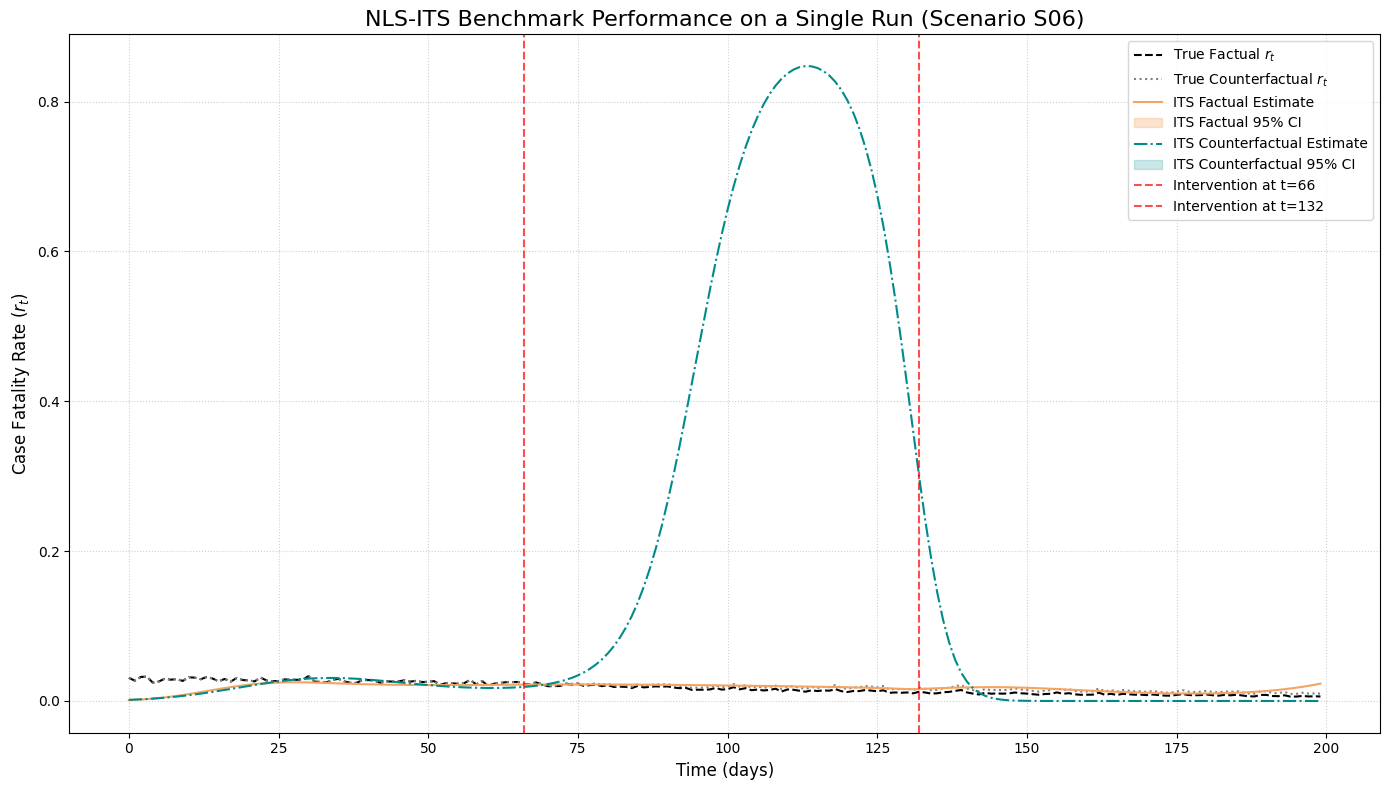

In [39]:
# --- 3. Analyze and Print Parameter Estimation Results ---
print("\n--- Parameter Estimation Results (NLS-ITS) ---")

num_interventions = sim_data["num_interventions_true_K"]
if num_interventions > 0:
    true_gammas = np.log(sim_data["true_beta_abs_0"] + 1e-9)
    true_lambdas = sim_data["true_lambda_0"]

    print("\n--- Gamma (log(beta_abs)) Estimates ---")
    for k in range(num_interventions):
        print(f"  gamma_{k+1}:")
        print(f"    True Value:              {true_gammas[k]:.4f}")
        print(f"    Estimated Value:         {its_results['its_gamma_est'][k]:.4f}")
        print(f"    95% CI:                  [{its_results['its_gamma_lower'][k]:.4f}, {its_results['its_gamma_upper'][k]:.4f}]")
        
    print("\n--- Lambda Estimates ---")
    for k in range(num_interventions):
        print(f"  lambda_{k+1}:")
        print(f"    True Value:              {true_lambdas[k]:.4f}")
        print(f"    Estimated Value:         {its_results['its_lambda_est'][k]:.4f}")
        print(f"    95% CI:                  [{its_results['its_lambda_lower'][k]:.4f}, {its_results['its_lambda_upper'][k]:.4f}]")

# --- 4. Visualize the Curve Fitting Results ---
print("\nGenerating plot...")
T_analyze = config.T_ANALYSIS_LENGTH
time_points = np.arange(T_analyze)

fig, ax = plt.subplots(figsize=(14, 8))

# Plot true curves
ax.plot(time_points, sim_data["true_r_0_t"][:T_analyze], color='black', linestyle='--', label="True Factual $r_t$")
ax.plot(time_points, sim_data["true_rcf_0_t"][:T_analyze], color='gray', linestyle=':', label="True Counterfactual $r_t$")

# Plot ITS factual estimate and its CI
ax.plot(time_points, its_results["its_factual_mean"][:T_analyze], color='sandybrown', label="ITS Factual Estimate")
ax.fill_between(
    time_points, 
    its_results["its_factual_lower"][:T_analyze], 
    its_results["its_factual_upper"][:T_analyze], 
    color='sandybrown', alpha=0.3, label="ITS Factual 95% CI"
)

# Plot ITS counterfactual estimate and its CI
ax.plot(time_points, its_results["its_counterfactual_mean"][:T_analyze], color='darkcyan', linestyle='-.', label="ITS Counterfactual Estimate")
ax.fill_between(
    time_points, 
    its_results["its_counterfactual_lower"][:T_analyze], 
    its_results["its_counterfactual_upper"][:T_analyze], 
    color='darkcyan', alpha=0.2, label="ITS Counterfactual 95% CI"
)

# Add vertical lines for interventions
for t_int in sim_data["true_intervention_times_0_abs"]:
    ax.axvline(x=t_int, color='r', linestyle='--', alpha=0.7, label=f"Intervention at t={int(t_int)}")

ax.set_title(f"NLS-ITS Benchmark Performance on a Single Run (Scenario {scenario_to_test_id})", fontsize=16)
ax.set_xlabel("Time (days)", fontsize=12)
ax.set_ylabel("Case Fatality Rate ($r_t$)", fontsize=12)
ax.legend(loc='best')
ax.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()

plt.show()

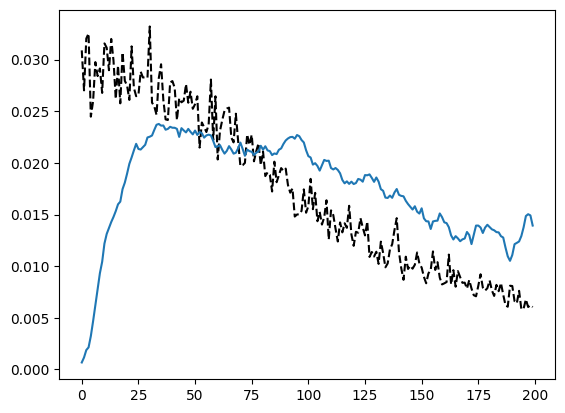

In [43]:
plt.plot(time_points, sim_data["true_r_0_t"][:T_analyze], color='black', linestyle='--', label="True Factual $r_t$")
plt.plot(time_points,naive_cfr[:200])